<a href="https://colab.research.google.com/github/Goshikhar23/DL-back-to-the-basics/blob/master/Generic_FFNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors 
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score, log_loss, mean_squared_error
from tqdm import tqdm_notebook
import seaborn as sns
import imageio
import time
from IPython.display import HTML

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


# Color Map

In [ ]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red", "yellow", "green"])

In [ ]:
np.random.seed(0)

# Generate Data

In [ ]:
data, labels = make_blobs(n_samples = 1000, n_features = 2, centers = 4, random_state=0)
print(data.shape, labels.shape)

(1000, 2) (1000,)


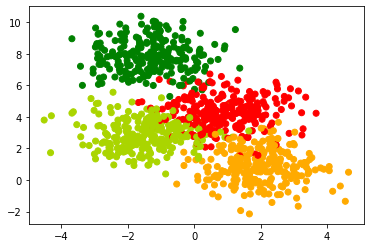

In [ ]:
plt.scatter(data[:,0], data[:, 1], c= labels, cmap= my_cmap)
plt.show()

## Converting into 2 labels

In [ ]:
labels_orig = labels
labels = np.mod(labels_orig, 2)

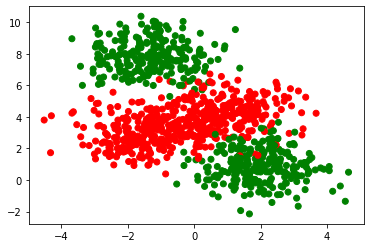

In [ ]:
plt.scatter(data[:,0], data[:, 1], c= labels, cmap= my_cmap)
plt.show()

# Multi-Class Classification

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels_orig, stratify=labels_orig, random_state=0)
print(X_train.shape, Y_train.shape)
print( X_val.shape, Y_val.shape)

(750, 2) (750,)
(250, 2) (250,)


In [ ]:
enc = OneHotEncoder()
y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
y_OH_val = enc.fit_transform(np.expand_dims(Y_val,1)).toarray()
print(y_OH_train.shape, y_OH_val.shape)

(750, 4) (250, 4)


# Generic FFN Class with vectorisation

In [ ]:
class FFN_vector():
  def __init__(self, n_inputs = 2, hidden_layers= [2], n_outputs= 4):
    self.nx = n_inputs
    self.ny = n_outputs
    self.nh = len(hidden_layers)
    self.sizes = [self.nx] + hidden_layers + [self.ny]   #list of neurons in layers 

    # Dictionary where key is layer no and value is matrices of weights b/w layer[i] and layer[i-1]
    self.W = {}
    self.B = {}
    # shapes for weights and biases at each layer
    for i in range(self.nh + 1):
      self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
      self.B[i+1] = np.zeros((1,self.sizes[i+1]))
    
  def sigmoid(self, X):
    return 1/(1+np.exp(-X))
  
  def softmax(self, X):
    exps = np.exp(X)
    return exps/np.sum(exps, axis=1).reshape(-1, 1)

  def forward_pass(self, X):  # Receives a matrix(whole data) instead of single x
    self.A = {}
    self.H = {}
    self.H[0] = X
    for i in range(self.nh+1):
      self.A[i+1] = np.matmul(self.H[i], self.W[i+1]) + self.B[i+1]
      self.H[i+1] = self.sigmoid(self.A[i+1])
    
    return self.H[self.nh+1]
  
  def grad_sigmoid(self, X):
    return X*(1 - X)
  
  def grad(self, X, Y):
    yHat = self.forward_pass(X)
    self.dW = {}
    self.dB = {}
    self.dH = {}
    self.dA = {}
    self.L = self.nh + 1
    

    self.dA[self.L] = (yHat - Y)
    for k in range(self.L, 0 , -1):
      self.dW[k] = np.matmul(self.H[k-1].T, self.dA[k])
      self.dB[k] = np.sum(self.dA[k], axis=0).reshape(1, -1)
      self.dH[k-1] = np.matmul(self.dA[k], self.W[k].T) 
      self.dA[k-1] = np.multiply(self.dH[k-1], self.grad_sigmoid(self.H[k-1]))

  def fit(self, X, Y, epochs=1, learning_rate=1, display_loss=False):

    if display_loss:
      loss = {}

    for i in tqdm_notebook(range(epochs), total= epochs, unit='epoch'):
      self.grad(X, Y)

      m = X.shape[0]

      for k in range(self.L, 0 , -1):
        self.W[k] -= learning_rate * (self.dW[k]/m)
        self.B[k] -= learning_rate * (self.dB[k]/m)

        if display_loss:
          Y_pred = self.predict(X)
          loss[i] = log_loss(np.argmax(Y, axis=1), Y_pred)

      
    if display_loss:
      plt.plot(list(loss.values()))
      plt.xlabel('Epochs')
      plt.ylabel('Log Loss')
      plt.show()
    
  
  def predict(self, X):
    Y_pred = self.forward_pass(X)
    return np.array(Y_pred).squeeze()


In [ ]:
model = FFN_vector(n_inputs = X_train.shape[1], hidden_layers=[4])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


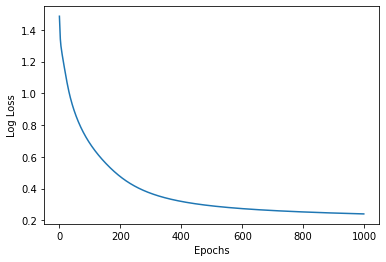

CPU times: user 2.94 s, sys: 23.8 ms, total: 2.97 s
Wall time: 2.98 s


In [ ]:
%%time
model.fit(X_train, y_OH_train, epochs = 1000, learning_rate=0.5, display_loss = True)

# Results

In [ ]:
Y_pred_train = model.predict(X_train)
Y_pred_train = np.argmax(Y_pred_train,1)
Y_pred_val = model.predict(X_val)
Y_pred_val = np.argmax(Y_pred_val,1)
accuracy_train = accuracy_score(Y_train, Y_pred_train)
accuracy_val = accuracy_score(Y_val, Y_pred_val)

print("Training accuracy", round(accuracy_train, 2))
print("Validation accuracy", round(accuracy_val, 2))

Training accuracy 0.91
Validation accuracy 0.93


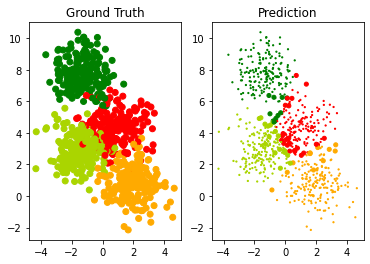

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.subplot(1, 2, 1)
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train, cmap=my_cmap)
plt.title("Ground Truth")
plt.subplot(1, 2, 2)
plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train))+.1))
plt.title("Prediction")
plt.show()
plt.tight_layout()